# Price Returns Forecasting with LightGBM  
  
This notebook attempts to forecast forward 1-week returns by using either 1) Technical Indicators and 2) timeseries features of `1W_RETURNS`.  

As the predictive performance falls short of reasonable accuracy, no backtesting of this strategy will be tried in this notebook. While it is not great for predicting directional returns, there seems to be scope for volatility prediction which is not explored here. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from warnings import simplefilter

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

from sklearn.model_selection import train_test_split

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plot_x_size = 15
plot_y_size = 2

import lightgbm as lgb

from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

import math
import talib as tal
import ta
import statsmodels.api as sm
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator

In [2]:
# Enter ticker symbol here
ticker = 'SPY'


# Read historical price data for ticker
filepath = f'./datasets/{ticker}.csv'
asset = pd.read_csv(filepath)
asset['Date'] = pd.to_datetime(asset['Date'])
asset.set_index('Date', inplace=True)

In [3]:
asset.head(10)

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,25.218233,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,25.397585,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,25.451389,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,25.720436,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,25.828053,531500
1993-02-05,44.96875,45.06250,44.71875,44.96875,25.810114,492100
1993-02-08,44.96875,45.12500,44.90625,44.96875,25.810114,596100
1993-02-09,44.81250,44.81250,44.56250,44.65625,25.630749,122100
1993-02-10,44.65625,44.75000,44.53125,44.71875,25.666630,379600


In [4]:
def create_ta(asset_df):
    """
    Creates column of Technical Analysis Indicators from either ta-lib or ta libraries
    """
    # Calculate Average Directional Value
    asset_df['ADX'] = tal.ADX(asset_df['HIGH'], asset_df['LOW'], asset_df['CLOSE'])
    # Calculate Commodity Channel Index
    asset_df['CCI'] = tal.CCI(asset_df['HIGH'], asset_df['LOW'], asset_df['CLOSE'])
    # Calculate Relative Strength Index
    asset_df['RSI'] = tal.RSI(asset_df['CLOSE'])
    # Calculate Mass Index
    asset_df['MASS_INDEX'] = ta.trend.mass_index(asset_df['HIGH'], asset_df['LOW'])
    # Calculate Donchian Channel index
    asset_df['DONCHIAN'] = ta.volatility.DonchianChannel(asset_df['HIGH'], asset_df['LOW'], asset_df['CLOSE']).donchian_channel_pband()
    # Calculate 1-Month returns
    asset_df['1M_RETURNS'] = (asset_df['ADJ CLOSE'].pct_change()+1).rolling(21).apply(lambda x: x.prod())-1
    # Calculate 3-Month returns
    asset_df['3M_RETURNS'] = (asset_df['ADJ CLOSE'].pct_change()+1).rolling(64).apply(lambda x: x.prod())-1

In [5]:
def create_ma(asset_df, window):
    """
    Add a column for Moving Average for the specified rolling window
    """
    asset_df[f'ma_{window}'] = asset_df['ADJ CLOSE'].rolling(window).mean()
    
    # Calculate log_return of the moving average price series
    asset_df[f'ma_{window}_log_return'] = np.log(asset_df[f'ma_{window}']/asset_df[f'ma_{window}'].shift(1))   

In [6]:
def calculate_weekly_returns(asset_df):
    """
    Returns a pd.DataFrame object with just the weekly returns calculated every Friday
    """
    weekly_returns = asset_df.copy().resample('W-FRI').last()['ADJ CLOSE'].pct_change().to_frame().rename(columns={'ADJ CLOSE':'1W_RETURNS'})
    weekly_returns.dropna(inplace=True)
    return weekly_returns  
    

In [8]:
def calculate_weekly_ta(asset_df, list_of_ta_features):
    """
    Aggregates daily data into weeklies. TA indicators are averaged for the week.
    """
    weekly_ta = asset_df.copy()[list_of_ta_features].resample('W-FRI').mean()
    weekly_ta['1W_RETURNS'] = asset_df.copy().resample('W-FRI').last()['ADJ CLOSE'].pct_change()
    return weekly_ta
    

## 1. Using TA Indicators to Predict Forward 1W_RETURNS

In [9]:
# Create the columns of technical indicators
create_ta(asset)
asset

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,ADX,CCI,RSI,MASS_INDEX,DONCHIAN,1M_RETURNS,3M_RETURNS
Date,,,,,,,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.218233,1003200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397585,480500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451389,201300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720436,529400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828053,531500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800,16.092604,111.093208,59.739623,24.785164,0.927547,0.052793,0.092184
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900,16.652488,98.696199,59.230404,24.622421,0.906596,0.036170,0.100237
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300,16.406721,72.892540,59.360537,24.576825,0.912315,0.051560,0.074537


In [10]:
asset_weekly_ta = calculate_weekly_ta(asset, ['ADJ CLOSE', 'ADX','CCI','RSI','MASS_INDEX','DONCHIAN','1M_RETURNS','3M_RETURNS'])
asset_weekly_ta

,ADJ CLOSE,ADX,CCI,RSI,MASS_INDEX,DONCHIAN,1M_RETURNS,3M_RETURNS,1W_RETURNS
Date,,,,,,,,,
1993-01-29,25.218233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-05,25.641515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023470
1993-02-12,25.698909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008340
1993-02-19,24.949185,NaN,-124.589865,44.444444,NaN,NaN,NaN,NaN,-0.023125
1993-02-26,25.300731,NaN,-24.851145,52.642754,NaN,0.689189,NaN,NaN,0.019369
...,...,...,...,...,...,...,...,...,...
2022-12-30,380.982498,15.655289,-62.307151,42.790922,24.925599,0.173922,-0.043732,0.047899,-0.001254
2023-01-06,383.010002,15.076383,9.257676,46.037881,25.488138,0.230683,-0.042440,0.041219,0.014774
2023-01-13,393.883990,15.005327,179.144008,56.352728,25.156194,0.617482,-0.002579,0.093347,0.026850


In [11]:
asset_weekly_ta.isnull().sum()

ADJ CLOSE      0
ADX            6
CCI            3
RSI            3
MASS_INDEX     9
DONCHIAN       4
1M_RETURNS     5
3M_RETURNS    14
1W_RETURNS     1
dtype: int64

In [12]:
asset_weekly_ta.dropna(inplace=True)

# Check number of NaNs
asset_weekly_ta.isnull().sum()

ADJ CLOSE     0
ADX           0
CCI           0
RSI           0
MASS_INDEX    0
DONCHIAN      0
1M_RETURNS    0
3M_RETURNS    0
1W_RETURNS    0
dtype: int64

In [13]:
# As we are predicting forward 1W_RETURNS, shift the rows by -1 so that we are using current day's features to predict the weekly returns next week 
asset_weekly_ta['1W_RETURNS'] = asset_weekly_ta['1W_RETURNS'].shift(-1)

# Drop the last row where 1W_RETURNS=NaN
asset_weekly_ta = asset_weekly_ta.dropna(subset=['1W_RETURNS'])
asset_weekly_ta

,ADJ CLOSE,ADX,CCI,RSI,MASS_INDEX,DONCHIAN,1M_RETURNS,3M_RETURNS,1W_RETURNS
Date,,,,,,,,,
1993-05-07,25.622055,25.061038,40.166371,50.827990,25.516418,0.613333,0.000910,0.003952,-0.007752
1993-05-14,25.564386,22.553292,34.433138,48.803843,24.861877,0.582982,-0.010697,-0.006891,0.017045
1993-05-21,25.744598,22.485542,64.837205,53.863482,24.933968,0.783249,0.002623,0.026737,0.010475
1993-05-28,26.090601,18.970397,121.768676,60.336188,25.477601,0.864751,0.034003,0.031241,0.001382
1993-06-04,26.233864,18.442487,76.173013,60.274280,24.861670,0.837302,0.025755,0.020204,-0.004141
...,...,...,...,...,...,...,...,...,...
2022-12-23,382.084003,15.401427,-119.530770,41.577108,24.392259,0.157527,-0.034148,0.014689,-0.001254
2022-12-30,380.982498,15.655289,-62.307151,42.790922,24.925599,0.173922,-0.043732,0.047899,0.014774
2023-01-06,383.010002,15.076383,9.257676,46.037881,25.488138,0.230683,-0.042440,0.041219,0.026850


In [14]:
# Make X feature inputs and set 1W_RETURNS as the target y variable
y = asset_weekly_ta.pop('1W_RETURNS')
X = asset_weekly_ta.drop(['ADJ CLOSE'], axis=1)

In [15]:
X

,ADX,CCI,RSI,MASS_INDEX,DONCHIAN,1M_RETURNS,3M_RETURNS
Date,,,,,,,
1993-05-07,25.061038,40.166371,50.827990,25.516418,0.613333,0.000910,0.003952
1993-05-14,22.553292,34.433138,48.803843,24.861877,0.582982,-0.010697,-0.006891
1993-05-21,22.485542,64.837205,53.863482,24.933968,0.783249,0.002623,0.026737
1993-05-28,18.970397,121.768676,60.336188,25.477601,0.864751,0.034003,0.031241
1993-06-04,18.442487,76.173013,60.274280,24.861670,0.837302,0.025755,0.020204
...,...,...,...,...,...,...,...
2022-12-23,15.401427,-119.530770,41.577108,24.392259,0.157527,-0.034148,0.014689
2022-12-30,15.655289,-62.307151,42.790922,24.925599,0.173922,-0.043732,0.047899
2023-01-06,15.076383,9.257676,46.037881,25.488138,0.230683,-0.042440,0.041219


In [16]:
y

Date
1993-05-07   -0.007752
1993-05-14    0.017045
1993-05-21    0.010475
1993-05-28    0.001382
1993-06-04   -0.004141
                ...   
2022-12-23   -0.001254
2022-12-30    0.014774
2023-01-06    0.026850
2023-01-13   -0.006575
2023-01-20    0.024755
Freq: W-FRI, Name: 1W_RETURNS, Length: 1551, dtype: float64

In [17]:
# Split into train and test sets
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=False)



# Model fitting with LightGBM
params = {
    'n_estimators':2000,
    'max_depth': 5,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart',
    'n_jobs': -1,
}


model_tsf = lgb.LGBMRegressor(first_metric_only=True, **params)

model_tsf.fit(np.array(train_X), train_y)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=5,
              n_estimators=2000, num_leaves=16)

In [18]:
# Make predictions on the validation set
y_preds = pd.Series(model_tsf.predict(val_X), index=val_X.index)

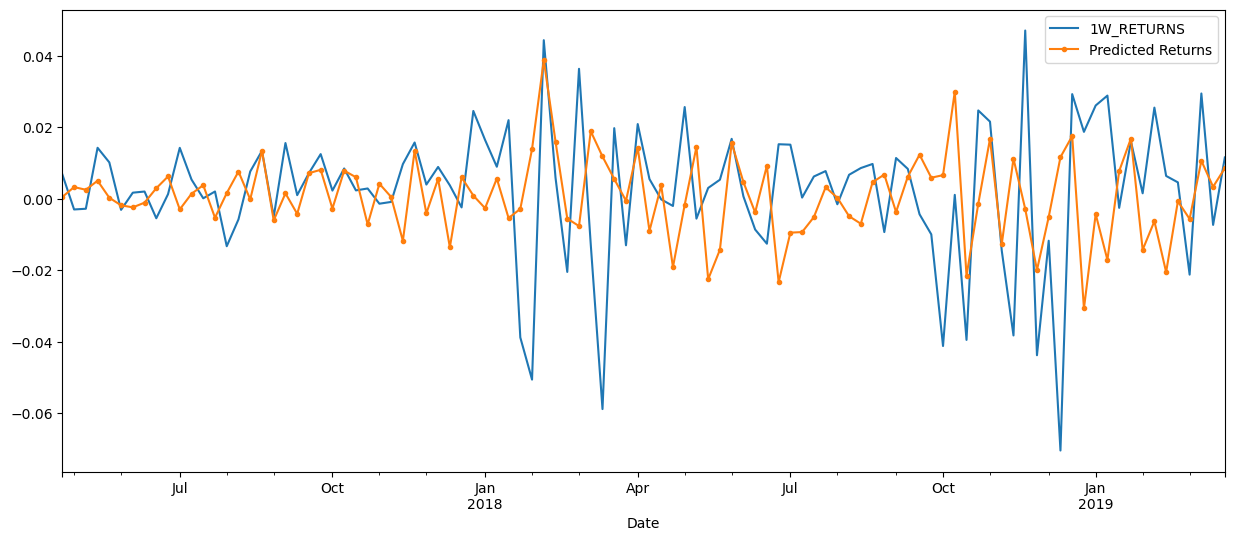

In [19]:
# Visualize both the val_y and y_preds to check accuracy
plt.figure(figsize=(15, 6))
val_y[-300:-200].plot(ax=plt.gca())
y_preds[-300:-200].plot(ax=plt.gca(), legend=None, marker=".", label='Predicted Returns');
plt.legend();


# The model preds hardly matched the actual '1W_RETURNS' in terms of direction. 
# However, the model preds was quite good at matching the magnitude(volatility) of the forward 1W_RETURNS.
# This model might be better adapted to volatility prediction than it is for directional returns prediction.

## 2. Using Timeseries Features to Predict Forward 1W_RETURNS

In [20]:
asset_weekly = calculate_weekly_returns(asset)
asset_weekly

,1W_RETURNS
Date,
1993-02-05,0.023470
1993-02-12,-0.008340
1993-02-19,-0.023125
1993-02-26,0.019369
1993-03-05,0.007741
...,...
2022-12-30,-0.001254
2023-01-06,0.014774
2023-01-13,0.026850


In [21]:
def interpret_dftest(dftest):
    """
    Interprets output of Dickey-Fuller test for stationarity
    
    dftest: adfuller(time_series)
    """
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
    return dfoutput

In [22]:
# Check stationarity of our target col first
interpret_dftest(adfuller(asset_weekly['1W_RETURNS']))

# Since p-value < alpha of 0.01, we will conclude that the regime_logit series is likely stationary
# No further differencing needed

Test Statistic   -1.632903e+01
p-value           3.074051e-29
dtype: float64

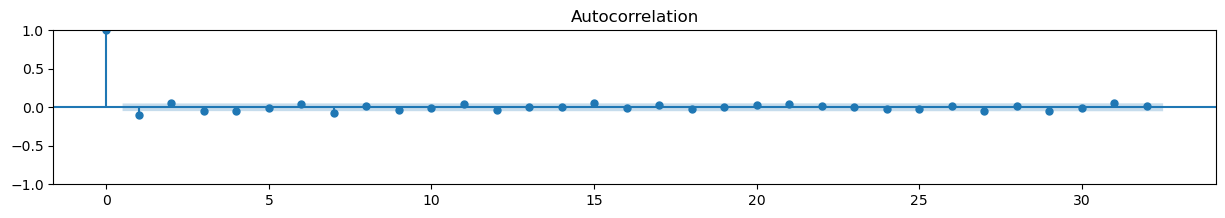

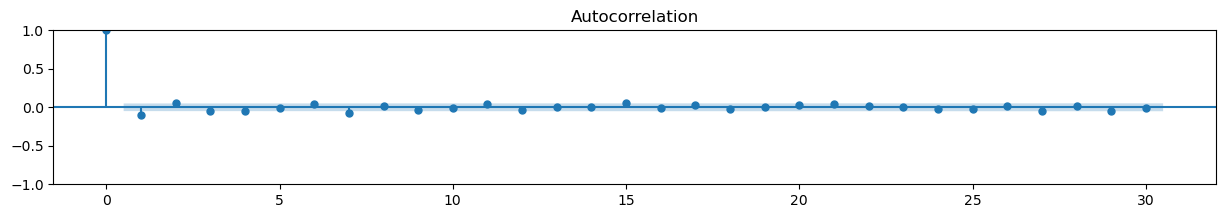

In [23]:
# Check for autocorrelation and seasonality
plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

plot_acf(asset_weekly['1W_RETURNS'])
plt.show()

plot_acf(asset_weekly['1W_RETURNS'], lags = 30, use_vlines = True)
plt.show()

# No autocorrelation and seasonality in weekly returns of SPY

In [24]:
def create_tsfeatures(asset_df, symbol):
    """
    Creates the timeseries features required from the 1W_RETURNS series
    
    :asset_df -> passed in need to have the column '1W_RETURNS' and requires a minimum of 20 rows
    :symbol -> ticker of asset in caps
    """
    # data preprocessing to create rolling windows for timeseries feature extraction
    returns = asset_df[['1W_RETURNS']].copy()
    returns['symbol'] = symbol
    returns['date'] = asset_df.index
    
    returns_rolled = roll_time_series(returns, column_sort='date', column_id='symbol', max_timeshift=20, min_timeshift=5)
    
    # extract timeseries features from each 20-period window
    extraction_settings = ComprehensiveFCParameters()
    X = extract_features(returns_rolled.drop('symbol', axis=1),
                            column_id='id', column_sort='date', column_value='1W_RETURNS',
                                impute_function=impute)
            
    # reindex to a datetimeindex
    X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
    X.index.name = 'last_date'
    return X
    

In [25]:
# Create timeseries features based on the '1W_RETURNS' feature only
asset_wf = create_tsfeatures(asset_weekly, 'SPY')


Feature Extraction: 100%|██████████| 20/20 [00:38<00:00,  1.91s/it]


In [26]:
# Merge the dataframes by index
asset_wf = pd.merge(asset_weekly, asset_wf, left_index=True, right_index=True)
asset_wf.head(20)

,1W_RETURNS,1W_RETURNS__variance_larger_than_standard_deviation,1W_RETURNS__has_duplicate_max,1W_RETURNS__has_duplicate_min,1W_RETURNS__has_duplicate,1W_RETURNS__sum_values,1W_RETURNS__abs_energy,1W_RETURNS__mean_abs_change,1W_RETURNS__mean_change,1W_RETURNS__mean_second_derivative_central,...,1W_RETURNS__fourier_entropy__bins_5,1W_RETURNS__fourier_entropy__bins_10,1W_RETURNS__fourier_entropy__bins_100,1W_RETURNS__permutation_entropy__dimension_3__tau_1,1W_RETURNS__permutation_entropy__dimension_4__tau_1,1W_RETURNS__permutation_entropy__dimension_5__tau_1,1W_RETURNS__permutation_entropy__dimension_6__tau_1,1W_RETURNS__permutation_entropy__dimension_7__tau_1,1W_RETURNS__query_similarity_count__query_None__threshold_0.0,1W_RETURNS__mean_n_absolute_max__number_of_maxima_7
1993-03-12,0.007682,0.0,0.0,0.0,0.0,0.026797,0.001649,0.020155,-0.003158,0.003969,...,1.386294,1.386294,1.386294,1.039721,1.098612,0.693147,-0.000000,2.708050,0.0,0.027229
1993-03-19,0.003330,0.0,0.0,0.0,0.0,0.030128,0.001660,0.017521,-0.003357,0.002746,...,1.039721,1.386294,1.386294,0.950271,1.386294,1.098612,0.693147,-0.000000,0.0,0.027229
1993-03-26,-0.002776,0.0,0.0,0.0,0.0,0.027352,0.001668,0.015891,-0.003749,0.002142,...,1.332179,1.609438,1.609438,0.867563,1.332179,1.386294,1.098612,0.693147,0.0,0.013294
1993-04-02,-0.018093,0.0,0.0,0.0,0.0,0.009258,0.001995,0.015819,-0.005195,0.001178,...,0.950271,1.332179,1.609438,0.796312,1.242453,1.332179,1.386294,1.098612,0.0,0.015403
1993-04-09,0.004252,0.0,0.0,0.0,0.0,0.013510,0.002013,0.016544,-0.002135,0.003385,...,1.560710,1.791759,1.791759,0.900256,1.475076,1.560710,1.609438,1.386294,0.0,0.015403
1993-04-16,0.014821,0.0,0.0,0.0,0.0,0.028331,0.002233,0.015947,-0.000865,0.002354,...,1.329661,1.560710,1.791759,1.149060,1.667462,1.747868,1.791759,1.609438,0.0,0.016423
1993-04-23,-0.026426,0.0,0.0,0.0,0.0,0.001905,0.002931,0.018247,-0.004536,-0.000472,...,1.153742,1.475076,1.945910,1.359237,1.831020,1.906155,1.945910,1.791759,0.0,0.019092
1993-04-30,0.006428,0.0,0.0,0.0,0.0,0.008334,0.002973,0.019464,-0.001420,0.002939,...,1.078992,1.078992,1.945910,1.540306,1.973001,2.043192,2.079442,1.945910,0.0,0.019092
1993-05-07,0.007097,0.0,0.0,0.0,0.0,0.015431,0.003023,0.018018,-0.001259,0.001353,...,1.494175,1.732868,1.906155,1.583258,2.098274,2.163956,2.197225,2.079442,0.0,0.019092
1993-05-14,-0.007752,0.0,0.0,0.0,0.0,0.007679,0.003083,0.017792,-0.002230,0.000652,...,1.320888,1.732868,1.906155,1.626021,2.210254,2.271869,2.302585,2.197225,0.0,0.019092


In [27]:
# As we are predicting forward 1W_RETURNS, shift the rows back -1 step so that we are using current day's features to predict the weekly returns next week 
asset_wf['1W_RETURNS'] = asset_wf['1W_RETURNS'].shift(-1)

# Drop the last row where 1W_RETURNS=NaN
asset_wf = asset_wf.dropna(subset=['1W_RETURNS'])
asset_wf

,1W_RETURNS,1W_RETURNS__variance_larger_than_standard_deviation,1W_RETURNS__has_duplicate_max,1W_RETURNS__has_duplicate_min,1W_RETURNS__has_duplicate,1W_RETURNS__sum_values,1W_RETURNS__abs_energy,1W_RETURNS__mean_abs_change,1W_RETURNS__mean_change,1W_RETURNS__mean_second_derivative_central,...,1W_RETURNS__fourier_entropy__bins_5,1W_RETURNS__fourier_entropy__bins_10,1W_RETURNS__fourier_entropy__bins_100,1W_RETURNS__permutation_entropy__dimension_3__tau_1,1W_RETURNS__permutation_entropy__dimension_4__tau_1,1W_RETURNS__permutation_entropy__dimension_5__tau_1,1W_RETURNS__permutation_entropy__dimension_6__tau_1,1W_RETURNS__permutation_entropy__dimension_7__tau_1,1W_RETURNS__query_similarity_count__query_None__threshold_0.0,1W_RETURNS__mean_n_absolute_max__number_of_maxima_7
1993-03-12,0.003330,0.0,0.0,0.0,0.0,0.026797,0.001649,0.020155,-0.003158,0.003969,...,1.386294,1.386294,1.386294,1.039721,1.098612,0.693147,-0.000000,2.708050,0.0,0.027229
1993-03-19,-0.002776,0.0,0.0,0.0,0.0,0.030128,0.001660,0.017521,-0.003357,0.002746,...,1.039721,1.386294,1.386294,0.950271,1.386294,1.098612,0.693147,-0.000000,0.0,0.027229
1993-03-26,-0.018093,0.0,0.0,0.0,0.0,0.027352,0.001668,0.015891,-0.003749,0.002142,...,1.332179,1.609438,1.609438,0.867563,1.332179,1.386294,1.098612,0.693147,0.0,0.013294
1993-04-02,0.004252,0.0,0.0,0.0,0.0,0.009258,0.001995,0.015819,-0.005195,0.001178,...,0.950271,1.332179,1.609438,0.796312,1.242453,1.332179,1.386294,1.098612,0.0,0.015403
1993-04-09,0.014821,0.0,0.0,0.0,0.0,0.013510,0.002013,0.016544,-0.002135,0.003385,...,1.560710,1.791759,1.791759,0.900256,1.475076,1.560710,1.609438,1.386294,0.0,0.015403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,-0.001254,0.0,0.0,0.0,0.0,-0.053966,0.021117,0.037862,-0.000227,-0.000246,...,1.468140,1.893788,2.397895,1.749494,2.659323,2.833213,2.772589,2.708050,0.0,0.044975
2022-12-30,0.014774,0.0,0.0,0.0,0.0,-0.058812,0.021105,0.036409,-0.001711,0.001165,...,1.373004,1.720193,2.397895,1.690772,2.582306,2.833213,2.772589,2.708050,0.0,0.044975
2023-01-06,0.026850,0.0,0.0,0.0,0.0,-0.077003,0.020237,0.034982,0.001319,0.001165,...,1.342113,1.893788,2.397895,1.690772,2.582306,2.751667,2.772589,2.708050,0.0,0.044975
2023-01-13,-0.006575,0.0,0.0,0.0,0.0,-0.038540,0.020823,0.034173,0.003336,0.000117,...,1.414279,1.972247,2.397895,1.677473,2.582306,2.751667,2.772589,2.708050,0.0,0.044975


In [28]:
# Make X feature inputs and set 1W_RETURNS as the target y variable
y2 = asset_wf.pop('1W_RETURNS')
X2 = asset_wf

In [29]:
# Split into train and test sets
train_X2, val_X2, train_y2, val_y2 = train_test_split(X2, y2, test_size=0.25, random_state=0, shuffle=False)

# Select the most informative features before modeling 
train_X2_selected = select_features(train_X2, train_y2)
val_X2_selected = val_X[train_X2_selected.columns]
train_X2_selected


# select_features() doesn't think that there are any significantly important features to predict train_y hence empty df here
# So instead, I am going to just dump in all the timeseries features generated into the LGBM model anyway..

""
1993-03-12
1993-03-19
1993-03-26
1993-04-02
1993-04-09
...
2015-07-03
2015-07-10
2015-07-17
2015-07-24


In [30]:
# Model fitting with LightGBM
params = {
    'n_estimators':2000,
    'max_depth': 5,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart',
    'n_jobs': -1,
}


model_tsf_2 = lgb.LGBMRegressor(first_metric_only=True, **params)

model_tsf_2.fit(np.array(train_X2), train_y2)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=5,
              n_estimators=2000, num_leaves=16)

In [31]:
# Make predictions on the validation set
y_preds2 = pd.Series(model_tsf_2.predict(val_X2), index=val_X2.index)

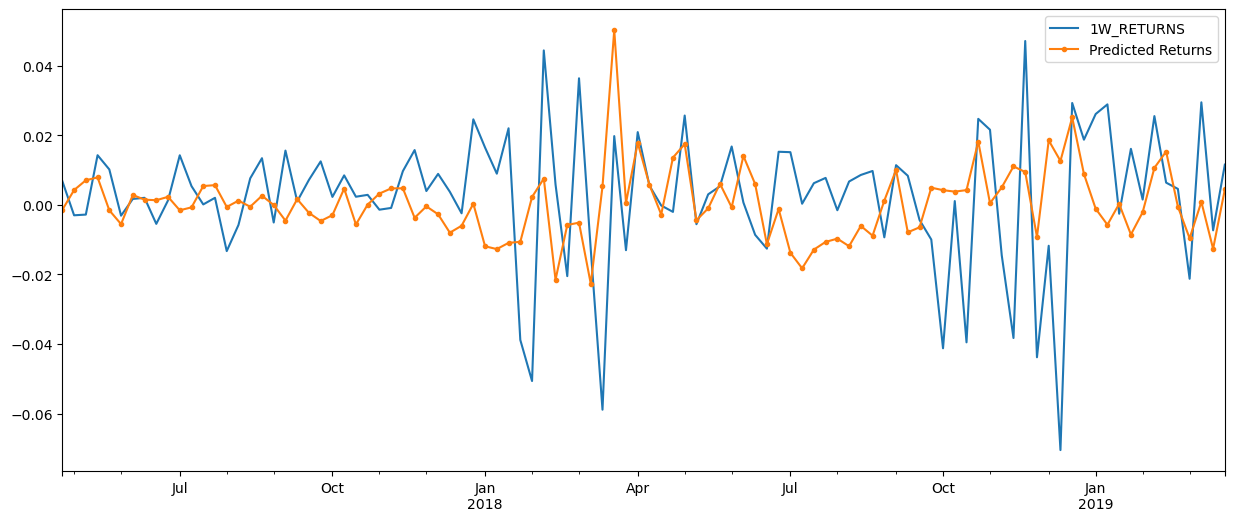

In [32]:
# Visualize both the val_y and y_preds to check accuracy
plt.figure(figsize=(15, 6))
val_y2[-300:-200].plot(ax=plt.gca())
y_preds2[-300:-200].plot(ax=plt.gca(), legend=None, marker=".", label='Predicted Returns')
plt.legend();


# Similarly bad observations as those trained using the TA features in part 1. 
# Largely inaccurate in predicting the direction of forward '1W_RETURNS' but matches the volatility of the returns to some extent

In [ ]:
|